In [1]:
import sys
sys.path.append('/Users/mte/Documents/McGill/Project/dFC/CODEs/methods_implementation/git_codes/BIC_codes/')
from functions.dFC_funcs import *
import numpy as np
import matplotlib.pyplot as plt
import hdf5storage
import scipy.io as sio
import os

In [2]:
###### DATA PARAMETERS ######
DATA_type = 'real' # 'real' or 'simulated'
num_subj = 2
select_nodes = True
rand_node_slct = False
num_select_nodes = 50
output_root = '/Users/mte/Documents/McGill/Project/dFC/RESULTs/methods_implementation/'
if DATA_type=='simulated':
    data_root = '/Users/mte/Documents/McGill/Project/dFC/DATA/TVB data/'
else:
    data_root = '/Users/mte/Documents/McGill/Project/dFC/DATA/HCP/HCP_Gordon/'

###### MEASUREMENT PARAMETERS ######
n_states = 12
n_subj_clstrs = 24
n_hid_states = 6
n_overlap = 0.5
W_sw = 44 # in seconds
n_jobs = 4
n_jobs_methods = 2



In [3]:
# HCP Data

if DATA_type=='real':

    session = '_Rest1_LR'

    # LOAD Region Location DATA

    locs = sio.loadmat(data_root+'Gordon333_LOCS.mat')
    locs = locs['locs']

    # LOAD Region Data

    file = data_root+'Gordon333_Key.txt'
    f = open(file, 'r')

    atlas_data = []
    for line in f:
        row = line.split()
        atlas_data.append(row)

    ALL_RECORDS = os.listdir(data_root)
    ALL_RECORDS = [i for i in ALL_RECORDS if 'Rest' in i]
    ALL_RECORDS.sort()
    SUBJECTS = list()
    for s in ALL_RECORDS:
        num = s[:s.find('_')]
        SUBJECTS.append(num)
    SUBJECTS = list(set(SUBJECTS))
    SUBJECTS.sort()

    SUBJECTS = SUBJECTS[0:num_subj]

    BOLD = None
    for subject in SUBJECTS:

        subj_fldr = subject + session

        # LOAD BOLD Data

        DATA = hdf5storage.loadmat(data_root+subj_fldr+'/ROI_data_Gordon_333_surf.mat')
        time_series = DATA['ROI_data']

        time_series = time_series.T

        time_series = time_series - np.repeat(np.mean(time_series, axis=1)[:,None], time_series.shape[1], axis=1) # ???????????????????????

        if BOLD is None:
            BOLD = TIME_SERIES(data=time_series, subj_id=subject, Fs=1/0.72, locs=locs, nodes_info=atlas_data, TS_name='BOLD Real')
        else:
            BOLD.append_ts(new_time_series=time_series, subj_id=subject)

    print(BOLD.n_regions, BOLD.n_time)


    # select nodes

    if select_nodes:
        if rand_node_slct:
            nodes_idx = np.random.choice(range(BOLD.n_regions), size=num_select_nodes, replace=False)
            nodes_idx.sort()
        else:
            nodes_idx = np.array(list(range(47, 88)) + list(range(224, 263)))
        BOLD.select_nodes(nodes_idx=nodes_idx)

    print(BOLD.n_regions, BOLD.n_time)


333 2400
80 2400


In [4]:
if DATA_type=='simulated':

    ###### BOLD DATA ######
    time_BOLD = np.load(data_root+'bold_time.npy')    
    time_series_BOLD = np.load(data_root+'bold_data.npy')

    BOLD = TIME_SERIES(data=time_series_BOLD.T, subj_idx=1, Fs=1/0.5, time_array=time_BOLD, TS_name='BOLD Simulation')

    ###### TAVG DATA ######
    time_Tavg = np.load(data_root+'TVB data/tavg_time.npy')    
    time_series_Tavg = np.load(data_root+'TVB data/tavg_data.npy')

    TAVG = TIME_SERIES(data=time_series_Tavg.T, subj_idx=1, Fs=200, time_array=time_Tavg, TS_name='Tavg Simulation')

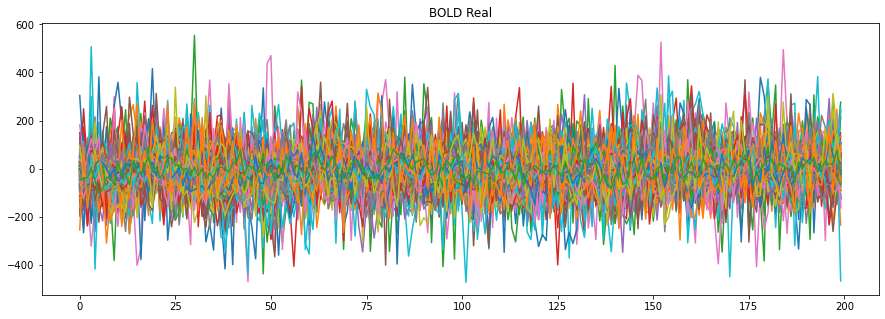

In [5]:
BOLD.visualize(interval=list(range(200)))

BOLD.truncate(start_point=None, end_point=1200)  

In [6]:
params = {'W': int(W_sw*BOLD.Fs), 'n_overlap': n_overlap,}

sw = SLIDING_WINDOW(sw_method='pear_corr', **params)

In [7]:
print("dFCM estimation started...")
dFCM = sw.estimate_dFCM(time_series=BOLD)
# dFCM = sw.estimate_dFCM(time_series=BOLD.get_subj_ts(subj_id='100206'))
print("dFCM estimation done.")

dFCM estimation started...
dFCM estimation done.


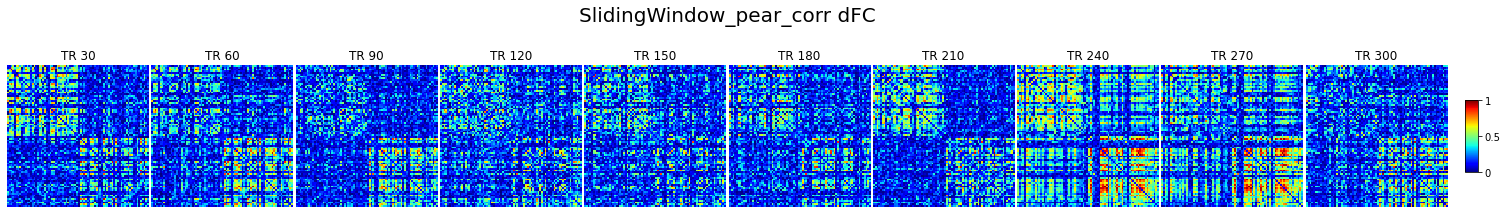

In [8]:
TRs = dFCM.TR_array[:10]
dFCM.visualize_dFC(TRs=TRs, normalize=True, threshold=0.0, fix_lim=True)

In [9]:
params = {'n_states': n_states}

hmm_cont = HMM_CONT(**params)

In [10]:
print("FCS estimation started...")
hmm_cont.estimate_FCS(time_series=BOLD)
print("FCS estimation done.")

print("dFCM estimation started...")
dFCM = hmm_cont.estimate_dFCM(time_series=BOLD)
print("dFCM estimation done.")

FCS estimation started...
FCS estimation done.
dFCM estimation started...
dFCM estimation done.


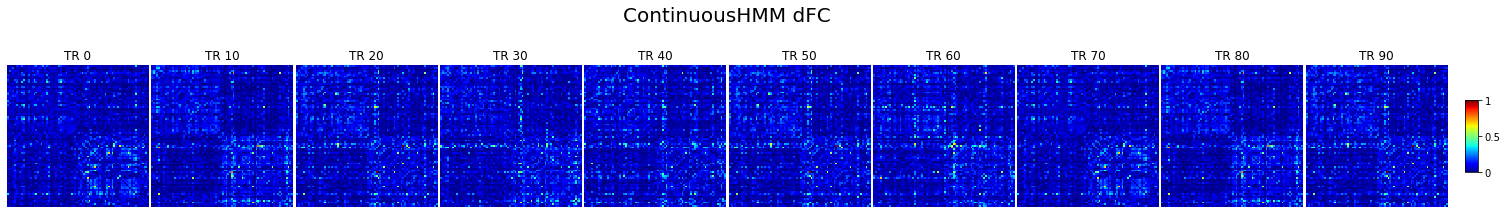

In [11]:
TRs = dFCM.TR_array[:100:10]
dFCM.visualize_dFC(TRs=TRs, normalize=True, threshold=0.0, fix_lim=True)

Analyzing Multiple dFC Methods

In [6]:
BOLD.truncate(start_point=None, end_point=None) 

In [7]:
params = {'W': int(W_sw*BOLD.Fs), 'n_overlap': n_overlap, \
    'n_states': n_states, 'n_subj_clstrs': n_subj_clstrs, 'n_hid_states': n_hid_states, \
    'n_jobs': n_jobs_methods, 'verbose': 0, 'backend': 'loky' \
            }

###### CONTINUOUS HMM ######
hmm_cont = HMM_CONT(**params)

###### WINDOW_LESS ######
windowless = WINDOWLESS(**params)

###### SLIDING WINDOW ######
sw_pc = SLIDING_WINDOW(sw_method='pear_corr', **params)
sw_mi = SLIDING_WINDOW(sw_method='MI', **params)

###### TIME FREQUENCY ######
time_freq_cwt = TIME_FREQ(method='CWT_mag', **params)
time_freq_wtc = TIME_FREQ(method='WTC', **params)

###### SLIDING WINDOW + CLUSTERING ######
swc_pc = SLIDING_WINDOW_CLUSTR(base_method='pear_corr', **params)
swc_wtc = SLIDING_WINDOW_CLUSTR(base_method='WTC', **params)

###### DISCRETE HMM ######
hmm_disc_pc = HMM_DISC(base_method='pear_corr', **params)
hmm_disc_wtc = HMM_DISC(base_method='WTC', **params)

MEASURES = [
    # hmm_cont, \
    # windowless, \
    # sw_pc, \
    # sw_mi, \
    # time_freq_cwt, \
    # time_freq_wtc, \
    swc_pc, \
    # swc_wtc, \
    # hmm_disc_pc,\
    # hmm_disc_wtc,\
            ]
        

dFC Analyzer

In [14]:
BOLD.data.

(80, 1201)

In [8]:
dFC_analyzer = DFC_ANALYZER(MEASURES_lst = MEASURES, vis_TR_idx=list(range(10, 20, 1)), \
    save_image=False, output_root=output_root,
    n_jobs=n_jobs, verbose=1, backend='loky' \
    )
    
dFC_analyzer.analyze(time_series=BOLD)

FCS estimation started...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


AttributeError: 'NoneType' object has no attribute 'astype'